@lohninger_typology_2020 review evidence from a variety of both "functional-typological and structural-grammatical approaches to complementation" [@givon_binding_1980; @cristofaro_subordination_2005; @noonan_complementation_2007; @dixon_basic_2009; @wurmbrand_implicational_2023] that "...there is a possibly universal implicational complementation hierarchy which is defined semantically and detectable through a diverse set of grammatical properties" and that "[w]hile the distribution of morphosyntactic properties varies significantly across languages, the semantic grouping of complement types shows a (more) stable distribution" (*ibid*, p. 33). The argue specifically that, while "different classification systems arise" in different works "[d]epending on the scope, focus and terminology of an approach", "a common property found in all approaches, in one form or another, is that complementation configurations are ranked along some kind of hierarchy" (*ibid*, p. 2).


In this module, we'll consider how we might develop a model that encodes this notion of hierarchy as a means of testing this idea at the scale of an entire lexicon. We of course won't be able to assess the idea cross-linguistically; but since all of these approaches make predictions of hierarchy language-internally, we will be able to probe it's ability to cover English.

## The MegaAcceptability dataset

We'll use the [MegaAcceptability dataset](http://megaattitude.io/projects/mega-acceptability/)–collected by @white_computational_2016 and reported on in detail by @white_frequency_2020.

In [1]:
#| code-fold: true
#| code-summary: Download the data

# !wget http://megaattitude.io/projects/mega-acceptability/mega-acceptability-v1.zip -P data/
# !unzip data/mega-acceptability-v1.zip -d data/

data_dir = "./data/mega-acceptability-v1/"

In [2]:
import os
from pandas import DataFrame, read_csv

def load_data(fname: str, verbose: bool = True) -> DataFrame:
    # read the raw data skipping comment rows at the beginning
    data = read_csv(fname, sep="\t")
    
    if verbose:
        n_datapoints = data.shape[0]
        print(f"The full dataset has {n_datapoints} datapoints.")
    
    # remove non-native speakers
    data = data.query("nativeenglish")
    
    if verbose:
        n_datapoints_native = data.shape[0]
        print(f"Removing {n_datapoints - n_datapoints_native} "
              "responses from nonnative speakers.")
    
    # remove NaN judgments
    data = data.query("~response.isnull()")
    
    if verbose:
        n_datapoints_nonnull = data.shape[0]
        print(f"Removing {n_datapoints_native - n_datapoints_nonnull} NA responses.")
    
    return data

Most importantly for our purposes, the dataset contains the `verb` and `frame` instantiated in the `sentence` that each `participant` rated on a 1-7 Likert `response` scale.^[In fact, not all predicates found in their sentences are necessarily verbs. Some–e.g. *annoy*–are likely to be (deverbal) adjectives in some frames. We'll continue to just refer to these predicates as verbs.]

In [3]:
data = load_data(os.path.join(data_dir, "mega-acceptability-v1.tsv"))

data[["participant", "verb", "frame", "sentence", "response"]].head()

The full dataset has 250000 datapoints.
Removing 600 responses from nonnative speakers.
Removing 10 NA responses.


,participant,list,presentationorder,verb,frame,response,nativeenglish,sentence
0,4,862,1,turn_out,NP was Ved whichNP to VP,2.0,True,Someone was turned out which thing to do.
1,381,862,1,turn_out,NP was Ved whichNP to VP,1.0,True,Someone was turned out which thing to do.
2,395,862,1,turn_out,NP was Ved whichNP to VP,2.0,True,Someone was turned out which thing to do.
3,621,862,1,turn_out,NP was Ved whichNP to VP,1.0,True,Someone was turned out which thing to do.
4,527,862,1,turn_out,NP was Ved whichNP to VP,1.0,True,Someone was turned out which thing to do.


The full distribution of ratings is similar to the one we saw for Sprouse et al.'s Experiments 1 and 3 in the sense that it shows that, in general, subjects prefer the ends of the scale. It differs mainly in the fact that there is a substantial bias toward 1 responses.

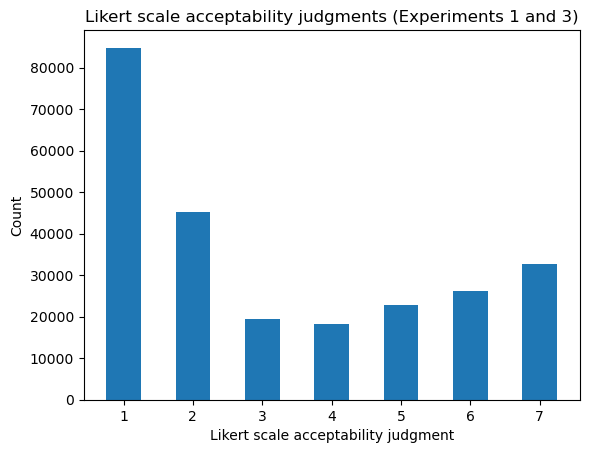

In [5]:
#| code-fold: true
#| code-summary: Plotting code

from numpy import arange
from matplotlib.pyplot import subplot

ax = subplot()
ax.hist(data.response, bins=arange(1, 9), rwidth=0.5, align="left")

ax.set_title("Likert scale acceptability judgments (Experiments 1 and 3)")
ax.set_xlabel("Likert scale acceptability judgment")
_ = ax.set_ylabel("Count")

This bias is perhaps unsurprising in light of the way that the dataset was constructed: many of the verb-frame combinations are bound to be bad together; and it gives a sense for how "sparse" the verb-frame acceptability matrix we attempt to estimate using our models is likely to be. On average, the mean `response` for each verb-frame pair is below 4.

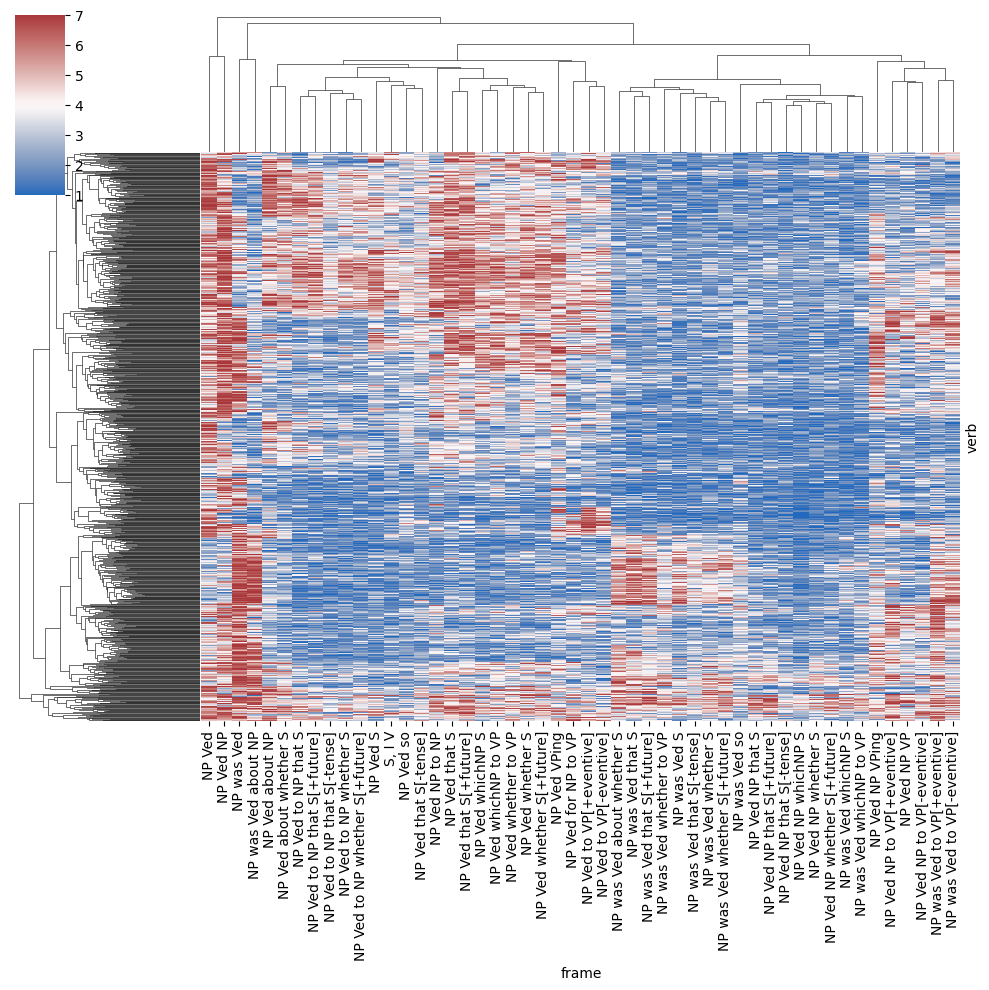

In [23]:
#| code-fold: true
#| code-summary: Plotting code

import warnings
warnings.filterwarnings("ignore")

from numpy import round, corrcoef
from pandas import Series
from seaborn import clustermap

verb_frame_means = data.pivot_table(
    index="verb", columns="frame", values="response"
)

_ = clustermap(
    verb_frame_means, cmap="vlag", figsize=(10, 10), 
    center=4, xticklabels=True, yticklabels=False
)

For reasons discussed in Module 1, we need to be careful in interpreting this sparsity–not least because there were many distinct lists and the distribution of true acceptability in the list almost certainly affected how subjects calibrated to the response scale. And so, following @white_computational_2016, we'll integrate an ordered logistic likelihood into all of our models. We'll first reimplement the model proposed by @white_computational_2016, then incrementally extend it to model the idea of homomorphic hierarchies of semantic and syntactic types discussed by @lohninger_typology_2020.

## Inducing semantic types by matrix factorization

@white_computational_2016 model the ordinal acceptability judgments $r_n$ associated with a sentence $\text{sent}(n)$ to be a function of the probability $\alpha_{vf}$ that the main clause verb $v = \text{verb}(n)$ in $\text{sent}(n)$ is acceptable in the syntactic frame $f = \text{frame}(i)$ instantiated in $\text{sent}(n)$. They model this probability as a function of two other kinds of probability: (i) the probability $\lambda_{vs}$ that a particular verb $v$ can have a particular semantic type signature $s$; and (ii) the probability $\pi_{fs}$ that a particular semantic type signature $s$ can be mapped onto a particular syntactic frame $f$.

The basic idea is that we should predict a verb to be good–modulo other factors [@grimshaw_complement_1979], such as its case assignment properties [@pesetsky_zero_1991]–in a particular syntactic frame insofar as it can have at least one semantic type signature that maps onto that frame. That is, they define the probability $\alpha_{vf}$ that a main clause verb $v$ is acceptable in a syntactic frame $f$ to be $p\left(\bigvee_s l_{vs} \land m_{fs}\right)$, where:

$$\begin{align*}
l_{vs} &= \begin{cases}
\top & \text{if } v \text{ can have semantic type signature } s\\
\bot & \text{otherwise}
\end{cases}\\
m_{fs} &= \begin{cases}
\top & \text{if } s \text{ can map onto syntactic frame } f\\
\bot & \text{otherwise}
\end{cases}
\end{align*}$$

Insofar as a verb's having a particular type signature is independent of that type signature mapping onto a particular syntactic frame, this probability can be *factored* into an expression in terms of $\lambda_{vs}$ and $\pi_{fs}$:

$$\begin{align*}
p\left(\bigvee_s l_{vs} \land m_{fs}\right) &= p\left(\lnot\lnot\bigvee_s l_{vs} \land m_{fs}\right)\\
&= 1 - p\left(\lnot\bigvee_s l_{vs} \land m_{fs}\right)\\
&= 1 - p\left(\bigwedge_s \lnot\left[ l_{vs} \land m_{fs}\right]\right)\\
&= 1 - \prod_s p\left(\lnot\left[ l_{vs} \land m_{fs}\right]\right)\\
&= 1 - \prod_s 1 - p\left(l_{vs} \land m_{fs}\right)\\
&= 1 - \prod_s 1 - p\left(l_{vs}\right)p\left(m_{fs}\right)\\
&= 1 - \prod_s 1 - \lambda_{vs}\pi_{fs}\\
\end{align*}$$

Importantly, they assume: (a) that verbs can be compatible with multiple semantic type signatures; (b) that multiple semantic type signatures can map onto the same frame; and (c) that multiple frames can be mapped onto by the same semantic type signature. So $\sum_s \lambda_{vs}$ and $\sum_s \pi_{fs}$ can be anywhere between $0$ and the number of type signatures, and $\sum_f \pi_{fs}$ can be anywhere between $0$ and the number of syntactic frames. None of the three need to be $1$.

### Matrix factorization

Solving for $\lambda_{vs}$ and $\pi_{fs}$, from which $\alpha_{vf}$ can be computed deterministically, is an instance of a [matrix factorization](https://en.wikipedia.org/wiki/Matrix_decomposition) problem–of which [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) [PCA; @pearson_lines_1901], [factor analysis](https://en.wikipedia.org/wiki/Factor_analysis), and [postive/non-negative matrix factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) [@paatero_positive_1994] are common forms. 

In matrix factorization, we assume some matrix $\mathbf{Y} \in \mathbb{R}^{N \times M}$ whose elements $y_{nm} \sim f(x_{nm}, \boldsymbol\theta)$ for some distribution $f$. The matrix $\mathbf{X}$ is itself *factorized* (or *decomposed*) into two matrices $\mathbf{U} \in \mathbb{R}^{N \times K}$ and $\mathbf{V} \in \mathbb{R}^{K \times M}$ such that $\mathbf{X} \equiv \mathbf{UV}$. 
For instance, in factor analysis (FA), $f \equiv \mathcal{N}$ and $\boldsymbol\theta \equiv \sigma^2$; and in postive/non-negative matrix factorization, all the matrices are constrained to contain positive/non-negative reals, with $f \equiv \text{HalfNormal}$ and $\boldsymbol\theta \equiv \sigma^2$. 

### Non-parametric priors

Following a method common in applications of matrix factorization, @white_computational_2016 select the number of semantic type signatures on the basis of an information criterion: the Akaike Information Criterion (AIC). Specifically, they sweep many values for the number of semantic types $K$–i.e. the dimensionality of $\boldsymbol\lambda_v$ and $\boldsymbol\pi_f$–fitting the model then asking which model yields the lowest AIC.

Rather than sweep many possible numbers of semantic type signatures, we'll use a nonparametric prior. Very roughly, the nonparametric prior we will use assumes that $\boldsymbol\lambda_v$ and $\boldsymbol\pi_f$–and consequently, $\mathbf{l}_v$ and $\mathbf{m}_v$–have infinite dimensional but that in our finite sample, we only observe a finite number of those dimensions being non-zero. This assumption is nice because it accords with one that we generally make in the formal semantics literature: the set of semantic types is defined inductively and is therefore infinite–though in a finite lexicon we are unlikely to see a predicate associated with every such type.

To implement this idea, we'll use a *stick-breaking process* proposed by @teh_stick-breaking_2007 (equation 5) to define our prior on the $\boldsymbol\lambda_v$. This process iteratively constructs the prior mean $\mu_k$ for each dimension (or *component*) $k$ in the following way.^[As @teh_stick-breaking_2007 note, this process is very closely related to the stick-breaking process associated with the [Dirichlet process](https://en.wikipedia.org/wiki/Dirichlet_process#The_stick-breaking_process), which is commonly used in the context of infinite mixture models. See, for instance, the [`BayesianGaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html) class from [`sklearn.mixture`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.mixture).]

$$\mu_s \equiv \begin{cases}
\sigma_s & \text{if } s = 1\\ 
\mu_{s-1}\sigma_s & \text{otherwise}
\end{cases}$$

where $\sigma_s \sim \text{Beta}(\alpha, 1)$.

In [27]:
from scipy.stats import beta

def sample_stick_breaking_process(k: int, alpha: float):
    return beta(alpha, 1).rvs(k).cumprod()

This process is useful because it allows us to approximate the prior means up to a particular number of components–usually relatively large one. One important thing to note about this process is that it strictly orders the types in terms of their mean, which can be seen if we sample many vectors of means from it.

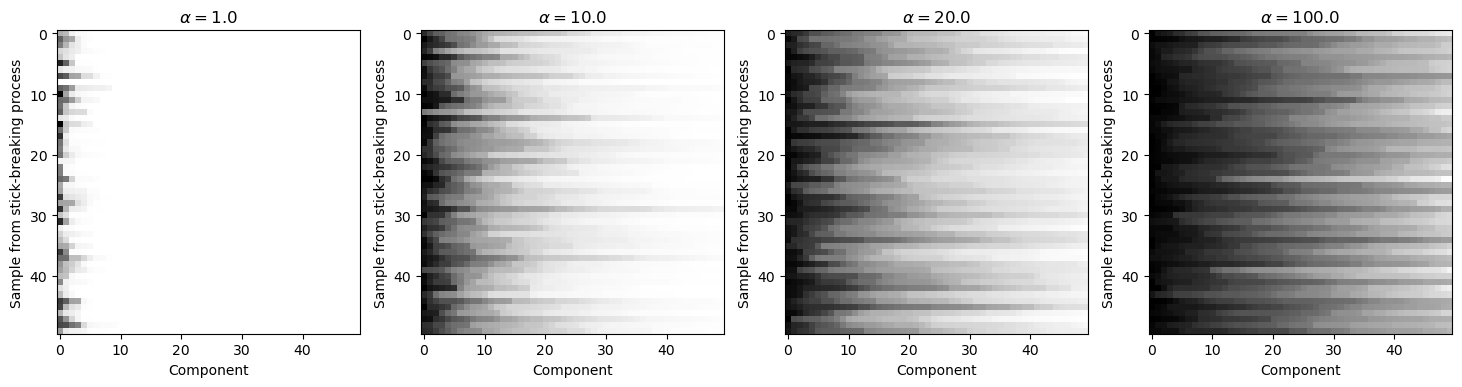

In [72]:
#| code-fold: true
#| code-summary: Plotting code

from numpy import array
from numpy import random
from matplotlib.pyplot import subplots

random.seed(30298)

fig, axes = subplots(1, 4, figsize=(18, 10))

for i, alpha in enumerate([1., 10., 20., 100.]):
    samples = array([
        sample_stick_breaking_process(k=50, alpha=alpha) for _ in range(50)
    ])
    img = axes[i].imshow(samples)
    axes[i].set_xlabel("Component")
    axes[i].set_ylabel("Sample from stick-breaking process")
    axes[i].set_title(r"$\alpha =$" + str(alpha))
    img.set_cmap('binary')

We'll then assume that $\lambda_{vs} \sim \text{Beta}\left(\nu^\text{verb}_s\mu^\text{verb}_s, \nu^\text{verb}_s\left(1-\mu^\text{verb}_s\right)\right)$ and $\pi_{fs} \sim \text{Beta}\left(\nu^\text{frame}_s\mu^\text{frame}_s, \nu^\text{frame}_s\left(1-\mu^\text{frame}_s\right)\right)$, with the *precision* (or *sample size*) $\nu^\text{verb}_s \sim \text{Exponential}(1)$ and  $\nu^\text{frame}_s \sim \text{Exponential}(1)$.

To get a sense for the sort of matrices $\boldsymbol\Lambda$ and $\boldsymbol\Pi$ this generates, we can simulate a draw.

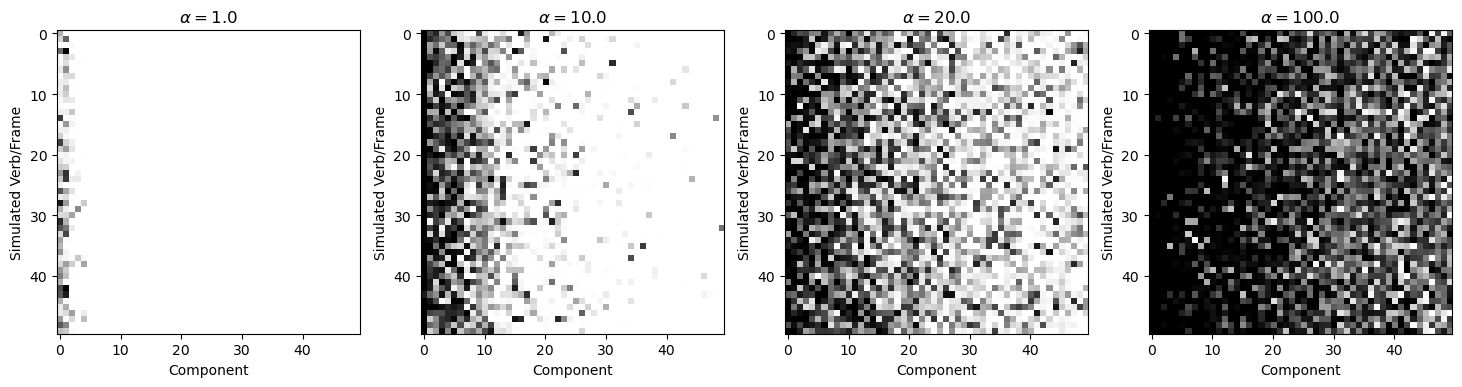

In [73]:
#| code-fold: true
#| code-summary: Plotting code

from scipy.stats import expon
random.seed(30298)

fig, axes = subplots(1, 4, figsize=(18, 10))

for i, alpha in enumerate([1., 10., 20., 100.]):
    means = sample_stick_breaking_process(k=50, alpha=alpha)
    precisions = expon(1).rvs(50)
    
    samples = array([
        beta(n*m, n*(1-m)).rvs(50) for m, n in zip(means, precisions)
    ]).T
    
    img = axes[i].imshow(samples)
    axes[i].set_xlabel("Component")
    axes[i].set_ylabel("Simulated Verb/Frame")
    axes[i].set_title(r"$\alpha =$" + str(alpha))
    img.set_cmap('binary')

Based on the observation by @white_computational_2016 that AIC selects a value of 12 components, a value of $\alpha=2.5$ seems likely to be a reasonable setting for the hyperprior.

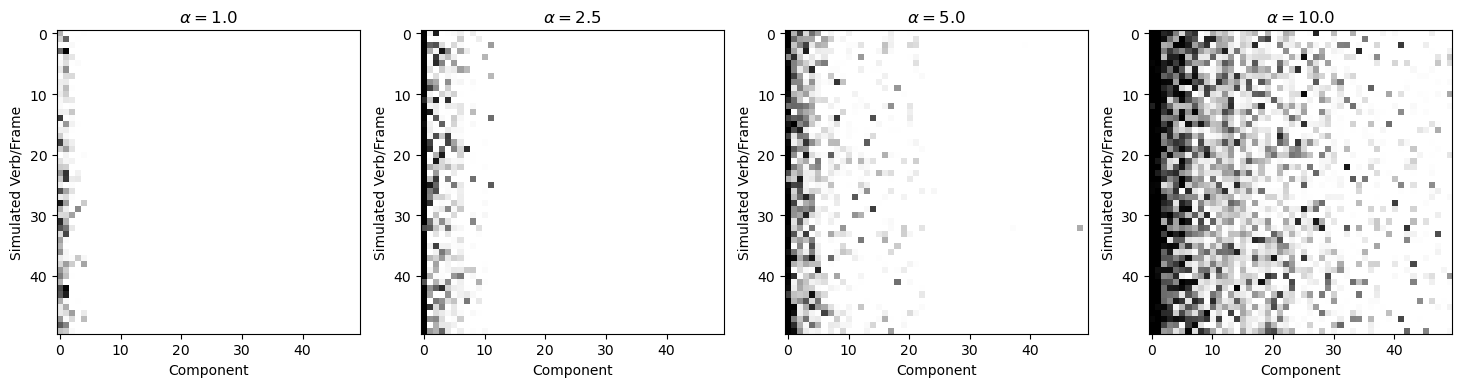

In [75]:
#| code-fold: true
#| code-summary: Plotting code

from scipy.stats import expon
random.seed(30298)

fig, axes = subplots(1, 4, figsize=(18, 10))

for i, alpha in enumerate([1., 2.5, 5., 10.]):
    means = sample_stick_breaking_process(k=50, alpha=alpha)
    precisions = expon(1).rvs(50)
    
    samples = array([
        beta(n*m, n*(1-m)).rvs(50) for m, n in zip(means, precisions)
    ]).T
    
    img = axes[i].imshow(samples)
    axes[i].set_xlabel("Component")
    axes[i].set_ylabel("Simulated Verb/Frame")
    axes[i].set_title(r"$\alpha =$" + str(alpha))
    img.set_cmap('binary')

### Implementation in STAN

We can implement this model in STAN fairly straightforwardly.

```{.stan include="models/selection-model.stan" start-line=1 end-line=12}
```

```{.stan include="models/selection-model.stan" start-line=14 end-line=32}
```

```{.stan include="models/selection-model.stan" start-line=34 end-line=104}
```

```{.stan include="models/selection-model.stan" start-line=106 end-line=129}
```

One issue with the implementation in STAN is that sampling under this parameterization turns out to be infeasible, so we need to turn to the sort of optimization discussed in the last section. STAN [supports](https://mc-stan.org/docs/reference-manual/optimization.html#optimization.chapter) this sort of optimization, but (as far I know) it does not support stochastic gradient ascent/descent.^[STAN does use [stochastic gradient ascent](https://mc-stan.org/docs/reference-manual/stochastic-gradient-ascent.html) in its implementation of automatic differentiation [variational inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods) (ADVI). But since I want to demonstrate MAP estimation and how to implement it in the popular `torch` framework here, I'm not going to use STAN's implementation of variational inference.] 

### Implementation in PyTorch

Using `torch` will give us the ability to implement MAP estimation with stochastic gradient descent. We basically need to design two components: (i) a `torch.nn.Module`, which is effectively used as a container for our models parameters that also specifies the analogue of STAN's `transformed parameters` block; and (ii) a trainer class that computes the posterior of those parameters against some data and runs stochastic gradient descent.^[There are other ways to set things up in `torch`, but this general approach is relatively common.] We'll specify the first here and the second in the next section.

We'll first specify a `dataclass` representing the data. 

In [76]:
from dataclasses import dataclass

@dataclass
class SelectionData:
    verb: ndarray
    frame: ndarray
    subj: ndarray
    resp: ndarray

NameError: name 'dataclass' is not defined

We'll also specify `dataclass`es that declare the paremeters that the model needs to have access to. We'll use `SelectionModelParametersABC` across all of our models.

In [ ]:
@dataclass
class SelectionModelParametersABC:
    n_verb: int
    n_frame: int
    n_subj: int
    n_resp_levels: int
    
@dataclass
class SelectionModelParameters(BaseSelectionModelParametersABC):
    n_component: int

Note that `SelectionModelParameters` does specify the parameter $\alpha$ of the stick-breaking process. This is because we only need $\alpha$ for computing the posterior–specifically, when we compute the prior–and so only the trainer needs to know it. 

As in Module 1, we'll us an ordered logistic likelihood. In contrast to that module, however, we will implement all cutpoints as subject-specific, and we'll place an exponential prior on their distances.

$$C_{sr} - C_{s(r-1)} \sim \text{Exponential}\left(\lambda^\text{subj}_r\right)$$

We'll furthermore center them so that the 4 bin generally corresponds to an acceptability of 0.5. This assumption is important not only for identifiability reasons, but also because, following @white_computational_2016, we assume that the value getting binned is $\text{logit}(\alpha)$, rather than $\alpha$ itself.  

In [ ]:
import torch
from torch import Tensor

def ordered_logistic_likelihood(value: Tensor, jumps: Tensor, center: bool = True) -> Tensor:
    """Compute the ordered logistic likelihood given a value
    
    Parameters
    ----------
    value
        The value to compute the likelihood for 
        (shape: batch_size)
    jumps
        The distance between cutpoints 
        (shape: batch_size x number of response levels - 1)

    Returns
    -------
    log_likelihood
        the ordered logistic log-likelihood
    """
    cutpoints = torch.cumsum(jumps, axis=1) 
    
    if center:
        cutpoints = cutpoints - cutpoints.mean(1)[:,None]
    
    cdfs = torch.sigmoid(cutpoints - value[:,None])

    low_prob = torch.cat(
        [torch.zeros([cdfs.shape[0], 1]), cdfs],
        axis=1
    )
    high_prob = torch.cat(
        [cdfs, torch.ones([cdfs.shape[0], 1])],
        axis=1
    )
    
    return high_prob - low_prob

The reasoning behind this assumption has to do with the fact that we can't simply bin directly on $[0, 1]$ due to the assumption that the noise term implicit in an ordered logistic is assumed to be distributed standard logistic and therefore most of the middle categories would get very little probability.^[We could alternatively learn a positive scaling term $\gamma$ for $\alpha^{vf}$ that would expand it to be on $[0, \gamma]$, but then we introduce an additional parameter that we need to worry about futzing with.]

In [ ]:
from torch import manual_seed
from torch.nn import Module, randn

ZERO = 1e-3
ONE = 1. - ZERO

class SelectionModel(Module):
    parameter_class = SelectionModelParameters
    data_class = SelectionData
    
    def __init__(self, parameters: SelectionModelParameters):
        super().__init__()
        
        self.model_parameters = parameters
        
        # prior parameters
        self.verb_component_prior_mean_aux = torch.nn.Parameter(
            randn(parameters.n_component), 
            requires_grad=True
        )
        self.frame_component_prior_mean_aux = torch.nn.Parameter(
            randn(parameters.n_component), 
            requires_grad=True
        )
        
        self.verb_component_prior_precision_aux = torch.nn.Parameter(
            randn(parameters.n_component), 
            requires_grad=True
        )
        self.frame_component_prior_precision_aux = torch.nn.Parameter(
            randn(parameters.n_component), 
            requires_grad=True
        )
        
        # latent matrices
        self.verb_component_aux = torch.nn.Parameter(
            randn([
                parameters.n_verb, parameters.n_component
            ]), 
            requires_grad=True
        )
        self.frame_component_aux = torch.nn.Parameter(
            randn([
                parameters.n_frame, parameters.n_component
            ]), 
            requires_grad=True
        )
        
        # likelihood parameters
        self.log_jumps = torch.nn.Parameter(
            torch.ones([
                parameters.n_subj, parameters.n_resp_levels-1
            ]), 
            requires_grad=True
        )

    def forward(self, data: SelectionData):
        # compute the verb frame probabilities
        verb_frame_prob = self.verb_frame_prob(
            data.verb, data.frame,
            clamp=True
        )
        
        # apply a logit to those probabilities
        verb_frame_logodds = torch.log(verb_frame_prob) -\
                             torch.log(1. - verb_frame_prob)
        
        # compute the jumps for each subject
        jumps = self.jumps[data.subj]
        
        # return the ordered logistic probabilities
        return ordered_logistic_likelihood(
            verb_frame_logodds, jumps
        )
    
    def verb_frame_prob(
        self, 
        verb_idx: Optional[ndarray] = None, 
        frame_idx: Optional[ndarray] = None,
        clamp: bool = False
    ) -> Tensor:
        if verb_idx is not None or frame_idx is not None:
            acc = 1. - torch.prod(
                1. - self.verb_component_prob[verb_idx,:] * 
                     self.frame_component_prob[frame_idx,:],
                axis=1
            ).clamp(ZERO, ONE)
        elif verb_idx is None and frame_idx is not None:
            acc = 1. - torch.prod(
                1. - self.verb_component_prob[:,None,:] * 
                     self.frame_component_prob[:,frame_idx,:],
                axis=2
            ).clamp(ZERO, ONE)
        elif verb_idx is not None and frame_idx is None:
            acc = 1. - torch.prod(
                1. - self.verb_component_prob[verb_idx,None,:] * 
                     self.frame_component_prob[None,:,:],
                axis=2
            ).clamp(ZERO, ONE)
        else:
            acc = 1. - torch.prod(
                1. - self.verb_component_prob[:,None,:] * 
                     self.frame_component_prob[None,:,:],
                axis=2
            )

        if clamp:
            return acc.clamp(ZERO, ONE)
        else:
            return acc
    
    @property
    def verb_component_prob(self) -> Tensor:
        return torch.sigmoid(self.verb_component_aux)
    
    @property
    def frame_component_prob(self) -> Tensor:
        return torch.sigmoid(self.frame_component_aux)
    
    @property
    def jumps(self):
        return torch.exp(self.log_jumps)
    
    @property
    def verb_component_prior_mean(self):
        return torch.sigmoid(self.verb_component_prior_mean_aux)
    
    @property
    def frame_component_prior_mean(self):
        return torch.sigmoid(self.frame_component_prior_mean_aux)
    
    @property
    def verb_component_prior_precision(self):
        return torch.exp(self.verb_component_prior_precision_aux)
    
    @property
    def frame_component_prior_precision(self):
        return torch.exp(self.frame_component_prior_precision_aux)

## Complex syntactic and semantic types

As mentioned by @white_computational_2016, this model of selection is very coarse-grained in that it fails to capture that both semantic and syntactic types have structure. This structure is important in the current context because the hypotheses that @lohninger_typology_2020 present make important refernce to the relationship between particular elements (or *primitive types*) that constitute a structured (or *complex*) type. For instance, @wurmbrand_implicational_2023 suggest that, while particular languages may make finer-grained distinctions, there are three coarse-grained semantic types that are mapped monotonically to three coarse-grained syntactic types, both ordered by some notion of containment [@ramchand_deriving_2014].

To incorporate this idea of structure into our models, the first thing we need to figure out is how to represent the distinction between a primitive type and a complex type. As I mentioned in [introducing the non-parametric prior](#non-parametric-priors) we added to White and Rawlins' model, in formal semantics following @montague_proper_1973, we tend to assume that complex semantic types $\mathcal{T} \equiv \bigcup_{j=1}^\infty \mathcal{T}_j$ are inductively defined in terms of some finite set of primitive types $\mathcal{T}_0$ and $\mathcal{T}_i = \left[\bigcup_{j=1}^{i-1} \mathcal{T}_j\right]^2$.

In [96]:
from typing import Generator, Optional, Union, Tuple, Set
from collections import defaultdict
from itertools import product

PrimitiveType = str
ComplexType = Union[PrimitiveType, Tuple['ComplexType', 'ComplexType']]

def natural_numbers() -> Generator[int, None, None]:
    """The natural numbers excluding 0"""
    i = 0
    
    while True:
        i += 1
        yield i

def complex_types(
    primitive_types: Set[PrimitiveType], max_size: Optional[int] = None
) -> Generator[MontagueType, None, None]:
    types = defaultdict(list)
    
    for t in primitive_types:
        types[0].append(t)
        yield t
        
    for i in natural_numbers():
        if max_size is not None and i > max_size:
            break
            
        for j1 in range(i):
            for j2 in range(i):
                for t in product(types[j1], types[j2]):
                    types[i].append(t)
                    yield t
                    
for i, t in enumerate(complex_types({"e", "t"})):
    if i < 20:
        print(t)
    else:
        break

e
t
('e', 'e')
('e', 't')
('t', 'e')
('t', 't')
('e', 'e')
('e', 't')
('t', 'e')
('t', 't')
('e', ('e', 'e'))
('e', ('e', 't'))
('e', ('t', 'e'))
('e', ('t', 't'))
('t', ('e', 'e'))
('t', ('e', 't'))
('t', ('t', 'e'))
('t', ('t', 't'))
(('e', 'e'), 'e')
(('e', 'e'), 't')


A similar approach is taken in combinatory categorial grammar, where directed *type constructors* `\` and `/` are added [see @steedman_combinatory_2011 and references therein].

In [95]:
TypeConstructor = str
ComplexType = Union[PrimitiveType, Tuple['ComplexType', TypeConstructor, 'ComplexType']]

def natural_numbers() -> Generator[int, None, None]:
    """The natural numbers excluding 0"""
    i = 0
    
    while True:
        i += 1
        yield i

def complex_types(
    primitive_types: Set[PrimitiveType], 
    type_constructors: Set[TypeConstructor], 
    max_size: Optional[int] = None
) -> Generator[MontagueType, None, None]:
    types = defaultdict(list)
    
    for t in primitive_types:
        types[0].append(t)
        yield t
        
    for i in natural_numbers():
        if max_size is not None and i > max_size:
            break
            
        for j1 in range(i):
            for j2 in range(i):
                for t in product(types[j1], type_constructors, types[j2]):
                    types[i].append(t)
                    yield t
                    
for i, t in enumerate(complex_types({"NP", "S"}, {r"\\", "/"})):
    if i < 20:
        print(t)
    else:
        break

NP
S
('NP', '\\\\', 'NP')
('NP', '\\\\', 'S')
('NP', '/', 'NP')
('NP', '/', 'S')
('S', '\\\\', 'NP')
('S', '\\\\', 'S')
('S', '/', 'NP')
('S', '/', 'S')
('NP', '\\\\', 'NP')
('NP', '\\\\', 'S')
('NP', '/', 'NP')
('NP', '/', 'S')
('S', '\\\\', 'NP')
('S', '\\\\', 'S')
('S', '/', 'NP')
('S', '/', 'S')
('NP', '\\\\', ('NP', '\\\\', 'NP'))
('NP', '\\\\', ('NP', '\\\\', 'S'))


So both complex semantic types and complex syntactic types can be viewed as binary trees with type constructors as the non-terminals and the primitive types as the terminals. 

We could imagine stating the generalizations described by @lohninger_typology_2020 in terms of ordered equivalence classes on these sorts of types. What's crucial in this case is that the types form an equivalence class–not which types are contained in each class. So really we just want to be able to represent the equivalence class, which we can do without recognizing its constituency. That is, we can simply view the equivalence classes as primitive (i.e. unstructured) types that potentially have an ordering relation on them (probably determined by their constituency). A simple way to do this is to represent primitive semantic and syntactic types as integers.

Can we get away from having to represent complex types at all then? No. The reason is that clauses are not the only constituents in many of these sentences. []{#exm-tell-good} []{#exm-tell-bad} For instance, to explain why (@exm-tell-good) is more acceptable than (@exm-tell-bad), we want to be able to appeal to two things: (i) that *tell* is good with finite clauses–e.g. because its type lives in a semantic equivalence class that maps onto a syntactic equivalence class that can be realized as *that something happened*; but also (ii) that *tell* prefers to have a direct object. 

(@exm-tell-good) Someone told someone that something happened.
(@exm-tell-bad) Someone told that something happened.

So basically, we can't abstract away *all* of the structure in the semantic and syntactic types. We need to retain some sorts of structure–e.g. the distinction between direct objects and clausal complements–while abstracting away others–e.g. what exactly the semantic and syntactic type of the clausal complement is in a relatively fine-grained type system like Montague's. We'll do this by viewing complex semantic and syntactic types as strings of primitive types. We'll consider two ways of doing this: one that constrains the explanation of acceptability by an inherent ordering on primitive types and another that is unconstrained by this ordering. 

So complex types will be strings of integers. Adding this structure in turn requires us to handle types of different complexity–e.g. that the complex syntactic type associated with (@exm-tell-good) contains two primitive types while the one associated with (@exm-tell-bad) contains two. We'll do this by thinking of all types as having the same complexity but by introducing the notion of a special null primitive type that "pads out" types of lower complexity.  

### Relationships among representations

The second thing we must handle is how to represent some additional relationships that we didn't have to before.

#### Primitive type relationships

We'll need to represent the relationship between semantic and syntactic primitive types as well as the relationship between syntactic primitive types and the constituents that may realize them. We'll do both using matrices of probabilities similar to the ones we used in implemented White and Rawlins' model–i.e. that are interpreted representing the probability that a particular object *can* be associated with some other object. 

We'll represent the relationship between semantic and syntactic primitive types in a matrix of probabilities $\boldsymbol\Phi^\text{synsem} \in [0, 1]^{(K_\text{sem} + 1) \times (K_\text{syn} + 1)}$, where $K_\text{sem}$ is the number of semantic primitive types, $K_\text{syn}$ is the number of syntactic primitive types, and the additional type handles a null type. We'll assume that null types only map onto other null types–$\phi^\text{synsem}_{00} = 1$ and $\phi^\text{synsem}_{0t} = \phi_{t0} = 0$ for all non-null types $t$. 

When the model incorporates ordering on the primitive types, we will constrain the mapping by the ordering by assuming that each non-null primitive type $t$ is associated with some probability distribution over $K_\text{rank}$ ranks $\chi^\text{synsem} \sim \text{OrderedLogistic}(\zeta_t^\text{sem}, \mathbf{\kappa})$ and that $\phi^\text{synsem}_{tt'} \equiv \mathbb{P}\left(\chi_{t} = \chi_{t'}\right) = \sum_i \mathbb{P}\left(\chi_{t} = i\right)\mathbb{P}\left(\chi_{t'} = i\right)$. For instance, for wurmbrand_implicational_2023, $K_\text{rank} = 3$.

We'll represent the relationship between syntactic primitive types and the constituents that may realize them in a similar way: a matrix of probabilities $\boldsymbol\Phi^\text{syn} \in [0, 1]^{(K_\text{syn} + 1) \times K_\text{const}}$. We'll assume that $\phi^\text{syn}_{0i} = 0$ for all constituents $i$–i.e. that the null type doesn't map to any constituent–and that frames are decomposed into constituents in the following way (expand to see the frame-to-constituent mapping).

In [97]:
#| code-fold: true
#| code-summary: Frame-to-constitutent mapping

from collections import OrderedDict

frame_to_constituents = OrderedDict({
    'NP was Ved whichNP to VP': {
        ("NP_subj", "NP_obj", "whichNP to VP"),
        ("NP_obj", "whichNP to VP")
    }, 
    'NP Ved for NP to VP': {
        ("NP_subj", "for NP to VP"), 
        ("NP_subj", "PP_for", "to VP")
    },
    'NP Ved NP to VP[+eventive]': {
        ("NP_subj", "NP to VP[+eventive]"), 
        ("NP_subj", "NP_obj", "to VP[+eventive]")
    }, 
    'NP was Ved whether to VP': {
        ("NP_subj", "NP_obj", "whether to VP"),
        ("NP_obj", "whether to VP")
    },
    'NP Ved to VP[+eventive]': {
        ("NP_subj", "to VP[+eventive]")
    }, 
    'NP Ved NP to NP': {
        ("NP_subj", "NP_obj", "NP_iobj") 
    }, 
    'NP Ved NP that S': {
        ("NP_subj", "NP_obj", "that S") 
    },
    'NP was Ved about NP': {
        ("NP_subj", "NP_obj", "about NP") ,
        ("NP_obj", "about NP") 
    }, 
    'NP was Ved that S[-tense]': {
        ("NP_subj", "NP_obj", "S[-tense]") ,
        ("NP_obj", "S[-tense]") 
    },
    'NP Ved to NP that S[+future]': {
        ("NP_subj", "NP_iobj", "that S[+future]") 
    }, 
    'NP Ved whether to VP': {
        ("NP_subj", "whether to VP")
    },
    'NP Ved whichNP to VP': {
        ("NP_subj", "whichNP to VP")
    }, 
    'NP Ved about whether S': {
        ("NP_subj", "about whether S") 
    },
    'NP Ved whichNP S': {
        ("NP_subj", "whichNP S")
    }, 
    'NP Ved that S[-tense]': {
        ("NP_subj", "that S[-tense]") 
    },
    'NP Ved whether S[+future]': {
        ("NP_subj", "whether S[+future]") 
    }, 
    'NP was Ved that S[+future]': {
        ("NP_subj", "NP_obj", "that S[+future]") ,
        ("NP_obj", "that S[+future]") 
    },
    'NP Ved to NP whether S': {
        ("NP_subj", "NP_iobj", "whether S") 
    }, 
    'NP Ved': {
        ("NP_subj",)
    }, 
    'NP Ved NP to VP[-eventive]': {
        ("NP_subj", "NP to VP[-eventive]"), 
        ("NP_subj", "NP_obj", "to VP[-eventive]"),
        ("NP_subj", "NP to VP[-eventive]")
    },
    'NP was Ved so': {
        ("NP_obj", "so"), 
        ("NP_subj", "NP_obj", "so")
    }, 
    'NP Ved so': {
        ("NP_subj", "so")
    }, 
    'NP Ved NP that S[+future]': {
        ("NP_subj", "NP_obj", "that S[+future]")
    },
    'NP Ved NP whether S[+future]': {
        ("NP_subj", "NP_obj", "whether S[+future]")
    }, 
    'NP Ved to NP whether S[+future]': {
        ("NP_subj", "NP_iobj", "whether S[+future]")
    },
    'NP was Ved that S': {
        ("NP_obj", "that S"), 
        ("NP_subj", "NP_obj", "that S")
    }, 
    'NP Ved NP whether S': {
        ("NP_subj", "NP_obj", "whether S")
    }, 
    'NP was Ved whether S': {
        ("NP_obj", "whether S"), 
        ("NP_subj", "NP_obj", "whether S")
    },
    'NP was Ved to VP[-eventive]': {
        ("NP_obj", "to VP[-eventive]"), 
        ("NP_subj", "NP_obj", "to VP[-eventive]"),
        ("NP_subj", "NP to VP[-eventive]")
    }, 
    'NP Ved NP VP': {
        ("NP_subj", "NP_obj", "VP"),
        ("NP_subj", "NP VP")
    }, 
    'NP Ved VPing': {
        ("NP_subj", "VPing")
    },
    'NP was Ved to VP[+eventive]': {
        ("NP_obj", "to VP[+eventive]"), 
        ("NP_subj", "NP_obj", "to VP[+eventive]"),
        ("NP_subj", "NP to VP[+eventive]")
    }, 
    'NP Ved NP that S[-tense]': {
        ("NP_subj", "NP_obj", "that S[-tense]")
    },
    'NP Ved that S': {
        ("NP_subj", "that S")
    }, 
    'NP was Ved': {
        ("NP_obj",), 
        ("NP_subj", "NP_obj")
    }, 
    'NP Ved S': {
        ("NP_subj", "S")
    },
    'NP Ved that S[+future]': {
        ("NP_subj", "that S[+future]")
    }, 
    'NP was Ved about whether S': {
        ("NP_subj", "NP_obj", "about whether S") ,
        ("NP_obj", "about whether S") 
    },
    'NP Ved NP': {
        ("NP_subj", "NP_obj") 
    }, 
    'NP Ved NP VPing': {
        ("NP_subj", "NP_obj", "VPing"),
        ("NP_subj", "NP VPing")
    }, 
    'NP Ved NP whichNP S': {
        ("NP_subj", "NP_obj", "whichNP S")
    },
    'NP Ved about NP': {
        ("NP_subj", "about NP") 
    }, 
    'NP was Ved S': {
        ("NP_subj", "NP_obj", "S") ,
        ("NP_obj", "S") 
    }, 
    'NP Ved to NP that S': {
        ("NP_subj", "NP_iobj", "that S"),
    },
    'NP was Ved whether S[+future]': {
        ("NP_subj", "NP_obj", "whether S[+future]") ,
        ("NP_obj", "whether S[+future]") 
    }, 
    'NP Ved whether S': {
        ("NP_subj", "whether S") 
    },
    'NP was Ved whichNP S': {
        ("NP_subj", "NP_obj", "whichNP S") ,
        ("NP_obj", "whichNP S") 
    }, 
    'NP Ved to NP that S[-tense]': {
        ("NP_subj", "NP_iobj", "that S[-tense]")
    },
    'NP Ved to VP[-eventive]': {
        ("NP_subj", "to VP[-eventive]")
    }
})

data = data[data.frame.isin(frame_to_constituents)]

The thing to notice about these frame decompositions is that different frames have different possible *parses*. []{#exm-tell-passive} []{#exm-annoy-passive} []{#exm-annoy-active} []{#exm-happy} For instance, (@exm-tell-passive) should have the same parse as (@exm-tell-good), but (@exm-annoy-passive) might have the same parse as (@exm-annoy-active) or it might have a parse analogous to the clearly adjectival (@exm-happy).

(@exm-tell-passive) Someone was told that something happened.
(@exm-annoy-passive) Someone was annoyed that something happened.
(@exm-annoy-active) It annoyed someone that something happened.
(@exm-happy) Someone was happy that something happened.

So we need to represent that a particular syntactic type may onto any of these parses and still be good. We'll discuss how to do this shortly in terms of the following mapping from frames to parses to an indicator for whether that constituent is contained in that parse (expand to see). We'll call this mapping $\mathbf{C} \in \{0, 1\}^{F \times K_\text{parse} \times K_\text{const}}$, where $F$ is the number of frames, $K_\text{parse}$ is the maximum number of parses, and $K_\text{const}$ is the numberof constituent types.

In [101]:
#| code-fold: true
#| code-summary: Constituent-to-feature vector mapping

from numpy import array, zeros, where, isin
from xarray import DataArray

constituents = array(sorted({
    c 
    for tups in frame_to_constituents.values() 
    for t in tups 
    for c in t
}))

max_parses = max(
    len(t) 
    for tups in frame_to_constituents.values() 
    for t in tups 
)
    
frame_to_parse_constituent_indicators = zeros([
    len(frame_to_constituents), max_parses, len(constituents)
])
    
for i, (f, parses) in enumerate(frame_to_constituents.items()):
    for j, parse in enumerate(parses):
        for k, const in enumerate(parse):
            const_idx = where(constituents == const)[0][0]
            frame_to_parse_constituent_indicators[i,j,const_idx] = 1.
            
frame_to_parse_constituent_indicators = DataArray(
    frame_to_parse_constituent_indicators, 
    dims=["frame", "parse", "constituent"],
    coords={
        "frame": list(frame_to_constituents),
        "parse": list(range(max_parses)),
        "constituent": constituents,
    }
)

#### Complex type relationships

We'll assume that the relationship between semantic and syntactic primitive types determines the relationship between complex semantic and syntactic types. Specifically, we'll assume that for complex semantic type $\mathbf{t}^\text{sem}$ and complex syntactic type $\mathbf{t}^\text{syn}$, the probability that these types are related is $\phi^\text{synsem}_{\mathbf{t}_\text{sem}\mathbf{t}_\text{syn}} = \prod_i \pi_{t_i^\text{sem}t_i^\text{syn}}$.

Similarly, we'll assume that the relationship between syntactic primitive types and constituents that can realize them determines the relationship between complex syntactic types and frames. But since we also need to consider alternative parses for a particular frame $f$: $$\phi^\text{syn}_{\mathbf{t}^\text{syn}f} = 1 - \prod_p 1 - \prod_j (1-c_{fpj}) + 1 - \prod_i 1 - c_{fpj}^\text{const}\psi_{t_i^\text{syn}j}$$ Effectively, what we are computing here is the probability that, if we look across parses, there is a constituent that could be mapped onto by at least one of the types.^[One issue with this particular form is that it doesn't not enforce a one-to-one relationship between syntactic types and constituents. To enforce this relationship, we would need to do something a bit fancier.]

One thing to note about both $\boldsymbol\Phi$s is that they have $2L$ dimensions each, where $L$ is the maximum complexity (i.e. length) of the complex types, which we'll set to $3$ based on the maximum number of constituents in the frame decompositions above.

#### Relationship between verbs, frames, and complex types

Finally, we need some way of representing the relationship between a verb and a complex semantic type and the relationship between a frame and a complex syntactic type. We'll do this by extending $\boldsymbol\lambda_v$ and $\boldsymbol\pi_f$ from White and Rawlins' model such that $\lambda_{v\mathbf{t}}$ tracks the probability of verb $v$ having complex semantic type $\mathbf{t}$, and $\pi_{f\mathbf{t}}$ tracks the probability of frame $f$ having complex syntactic type $\mathbf{t}$. $\boldsymbol\Lambda$ and $\boldsymbol\Pi$ will thus be represented as *tensors*, with the first dimension corresponding to verb and frame, respectively, and each subsequent dimension $d$ representing a primitive type $t_d$ in position $d$ of complex type $\mathbf{t}$.

#### Definition of acceptability

Finally, we define the acceptability of a verb $v$ in a frame $f$ in terms of all of these relationships:

$$\alpha_{vf} \equiv 1 - \prod_{\mathbf{t}_\text{sem},\mathbf{t}_\text{syn}} 1 - \lambda_{v\mathbf{t}_\text{sem}}\phi^\text{synsem}_{\mathbf{t}_\text{sem}\mathbf{t}_\text{syn}}\phi^\text{syn}_{\mathbf{t}_\text{syn}f}\pi_{f\mathbf{t}_\text{syn}}$$

### Implementing the unconstrained model

To implement the unconstrained variant of our structured type models, we need to specify some additional parameters: our single `n_components` parameter gets replaced with a specification for the number of semantic (`n_primitive_semantic_types`) and syntactic (`n_primitive_syntactic_types`) primitive types, the `max_complex_type_size` (which we already said would be 3), and the `frame_to_parse_constituent_indicators` we constructed earlier.

In [ ]:
@dataclass
class StructuredSelectionModelParameters(BaseSelectionModelParameters):
    frame_to_parse_constituent_indicators: DataArray
    n_primitive_semantic_types: int
    n_primitive_syntactic_types: int
    max_complex_type_size: int

In [ ]:
from numpy import prod
from torch import Tensor

class StructuredSelectionModel(Module):
    parameter_class = StructuredSelectionModelParameters
    data_class = SelectionData
    
    def __init__(self, parameters: StructuredSelectionModelParameters):
        super().__init__()
        
        self.model_parameters = parameters
        
        # initialize the verb-complex semantic type probabilities
        verb_shape = (parameters.n_verb,) + self.complex_semantic_type_shape
        self.verb_complex_semantic_type_aux = torch.nn.Parameter(
            torch.randn(verb_shape), 
            requires_grad=True
        )
        
        # initialize the frame-complex syntactic type probabilities
        frame_shape = (parameters.n_frame,) + self.complex_syntactic_type_shape
        self.frame_complex_syntactic_type_aux = torch.nn.Parameter(
            torch.randn(frame_shape), 
            requires_grad=True
        )
        
        # initialize the semantic-syntactic primitive type map
        self._initialize_primitive_type_map()
        
        # initialize the syntactic primitive type-constituent map
        syntactic_primitive_type_constituent_map_aux = torch.zeros([
             parameters.n_primitive_syntactic_types + 1,
             parameters.frame_to_parse_constituent_indicators.shape[2]
        ])
        self.syntactic_primitive_type_constituent_map_aux = torch.nn.Parameter(
            syntactic_primitive_type_constituent_map_aux, 
            requires_grad=True
        )
        
        # initialize the cutpoint distances
        self.log_jumps = torch.nn.Parameter(
            torch.ones([
                parameters.n_subj, parameters.n_resp_levels-1
            ]), 
            requires_grad=True
        )

    def _initialize_primitive_type_map(self):
        primitive_type_map_aux = torch.zeros([
            self.model_parameters.n_primitive_semantic_types + 1, 
            self.model_parameters.n_primitive_syntactic_types + 1
        ])
        self.primitive_type_map_aux = torch.nn.Parameter(
            primitive_type_map_aux, 
            requires_grad=True
        )
        
    @property
    def complex_semantic_type_shape(self):
        return (self.model_parameters.n_primitive_semantic_types+1,) *\
               self.model_parameters.max_complex_type_size
    
    @property
    def complex_syntactic_type_shape(self):
        return (self.model_parameters.n_primitive_syntactic_types+1,)*\
               self.model_parameters.max_complex_type_size
        
    def forward(self, data: SelectionData):
        verb_frame_prob = self.verb_frame_prob(data.verb, data.frame)
        verb_frame_logodds = torch.log(verb_frame_prob) - torch.log(1. - verb_frame_prob)
        
        jumps = self.jumps[data.subj]
        
        return ordered_logistic_likelihood(
            verb_frame_logodds, jumps
        )
    
    def verb_frame_prob(self, verb_idx: ndarray, frame_idx: ndarray) -> Tensor:
        n_verb = self.model_parameters.n_verb
        n_frame = self.model_parameters.n_frame
        
        verb_shape = self.complex_semantic_type_shape +\
                     (1,) * len(self.complex_syntactic_type_shape)
        frame_shape = (1,) * len(self.complex_semantic_type_shape) +\
                      self.complex_syntactic_type_shape
            
        if verb_idx.shape != frame_idx.shape:
            raise ValueError
        else:
            resp_shape = verb_idx.shape[0]
            
        # shape for verbs and frames to complex type signatures
        verb_shape = (resp_shape,) + verb_shape
        frame_shape = (resp_shape,) + frame_shape

        # shape with response dimension inserted into map
        map_shape = (1,) + self.complex_type_map.shape

        # shape for computing prod on all but the reponse dimension
        flat_shape = (resp_shape, prod(map_shape))

        p = self.verb_complex_semantic_type[verb_idx].view(verb_shape) *\
            self.frame_complex_syntactic_type[frame_idx].view(frame_shape) *\
            self.complex_synsem_type_map.view(map_shape) *\
            self.complex_syn_type_map(frame_idx).view(map_shape)

        acc = 1. - (1. - p.view(flat_shape)).prod(axis=1)
        acc = acc.clamp(min=ZERO, max=ONE)

        return acc
            
    
    @property
    def verb_complex_semantic_type(self) -> Tensor:
        return torch.sigmoid(self.verb_complex_semantic_type_aux)
    
    @property
    def frame_complex_syntactic_type(self) -> Tensor:
        return torch.sigmoid(self.frame_complex_syntactic_type_aux)
    
    @property
    def primitive_type_map(self) -> Tensor:
        prob = torch.sigmoid(self.primitive_type_map_aux)
        
        # the 0th primitive type is the null primitive type and null 
        # primitive types should only map onto each other, we do this
        # by multiplying by a special mask
        mask = torch.ones_like(prob)
        mask[0,0] = 1/prob[0,0]
        mask[0,1:] = 0.0
        mask[1:,0] = 0.0
        
        return mask * prob
    
    @property
    def complex_synsem_type_map(self):
        # only want to compute the transformation implicit in the
        # property once
        primitive_type_map = self.primitive_type_map
        
        # the final shape of the complex type map
        final_shape = primitive_type_map.shape *\
                      self.model_parameters.max_complex_type_size
        
        shape = (primitive_type_map.shape[0],) +\
                (1,) * (self.model_parameters.max_complex_type_size - 1) +\
                (primitive_type_map.shape[1],) +\
                (1,) * (self.model_parameters.max_complex_type_size - 1)
        m = primitive_type_map.view(shape)
        
        for i in range(1, self.model_parameters.max_complex_type_size):
            shape = (1,) * i +\
                    (primitive_type_map.shape[0],) +\
                    (1,) * (self.model_parameters.max_complex_type_size - (i + 1)) +\
                    (1,) * i +\
                    (primitive_type_map.shape[1],) +\
                    (1,) * (self.model_parameters.max_complex_type_size - (i + 1))
            m = m * primitive_type_map.view(shape)
            
        return m
    
    def complex_syn_type_map(self, frame_idx: ndarray):
        parse_constituent_indicators = self.model_parameters.frame_to_parse_constituent_indicators[frame_idx]
        primitive_type_map = self.syntactic_primitive_type_constituent_map
        
        final_shape = frame_idx.shape +\
                      (self.model_parameters.n_primitive_syntactic_types,) *\
                      self.model_parameters.max_complex_type_size
        m = torch.zeros(final_shape)
        
        # frame x primitive type x parse x constituent type  
        map_shape = (1,) + primitive_type_map.shape[:1] + (1,) + primitive_type_map.shape[1:]
        indicators_shape = indicators_shape.shape[:1] + (1,) + indicators_shape.shape[1:]
        
        prob = 1. - torch.prod(
            1. - torch.prod(
                (1.-parse_constituent_indicators.view(indicators_shape)) + 
                1. - torch.prod(
                    1. - 
                    primitive_type_map.view(map_shape) * 
                    parse_constituent_indicators.view(indicators_shape), 
                    axis=1),
                axis=2
            ), axis=2
        ).view(final_shape)
            
        return m + prob
    
    @property
    def syntactic_primitive_type_constituent_map(self):
        prob = torch.sigmoid(
            self.syntactic_primitive_type_constituent_map_aux
        )

        # the 0th primitive type is the null primitive type and null 
        # primitive types should not map onto any constitutent, we do 
        # this by multiplying by a special mask
        mask = torch.ones_like(prob)
        mask[0,:] = 0.0
        
        return mask * prob
    
    @property
    def jumps(self):
        return torch.exp(self.log_jumps)

### Implementing the constrained model

To implement the constrained variant of the above model, we simply need to alter how the mapping from primitive semantic types to primitive semantic types operates.

In [ ]:
class ConstrainedStructuredSelectionModel(StructuredSelectionModel):
    
    def _initialize_primitive_type_map(self):
        primitive_type_rank_sem_aux = torch.zeros([
            self.model_parameters.n_primitive_semantic_types
        ])
        self.primitive_type_rank_sem_aux = torch.nn.Parameter(
            primitive_type_rank_sem_aux, 
            requires_grad=True
        )
        
        primitive_type_rank_syn_aux = torch.zeros([
            self.model_parameters.n_primitive_syntactic_types
        ])
        self.primitive_type_rank_syn_aux = torch.nn.Parameter(
            primitive_type_rank_syn_aux, 
            requires_grad=True
        )
        
        self.type_rank_log_jumps = torch.nn.Parameter(
            primitive_type_rank_syn_aux, 
            requires_grad=True
        )
        
    @property
    def primitive_type_map(self) -> Tensor:
        rank_jumps = torch.exp(self.type_rank_log_jumps)
        rank_cuts = torch.cumsum(rank_jumps, axis=0)
        
        prob_sem = ordered_logistic(
            self.primitive_type_rank_sem_aux[None,:], 
            rank_cuts[None,:]
        )
        prob_syn = ordered_logistic(
            self.primitive_type_rank_syn_aux[None,:], 
            rank_cuts[None,:]
        )
        
        prob_prim = prob_syn.transpose(1, 0) * prob_sem
        
        # the 0th primitive type is the null primitive type and null 
        # primitive types should only map onto each other, we do this
        # by multiplying by a special mask
        prob = torch.zeros((prob_prim.shape[0] + 1, prob_prim.shape[1] + 1))
        prob[0,0] = 1.0
        prob[1:,1:] = prob_prim
        
        return prob

## Summing up

We started with a relatively straightforward variant of matrix factorization as our model for inducing selection and augmented that out to a model that recognizes structured semantic and syntactic types. In the next section, we'll fit these models and probe the representations they learn.